In [1]:
import backdoor

In [2]:
import pymongo
conn=pymongo.MongoClient("mongodb://localhost:27017/")['backdoor']

In [3]:
tm1_results = list(conn['tm1_v3:reevaluation'].find({}))

tm1_badnet = [r for r in tm1_results if 'badnet' in r['weights']]
tm1_hc = [r for r in tm1_results if 'handcrafted' in r['weights']]

In [53]:
len(tm1_badnet), len(tm1_hc)

(50, 89)

In [54]:
tm3_clean = list(conn['tm3_v3:clean'].find({}))

In [55]:
len(tm3_clean)

50

In [59]:
# Backdoor success rate is 1-x['stats']['test_bd_neg_stats']['test_bd_neg_acc']

selector = lambda x: 1-x['stats']['test_bd_neg_stats']['test_bd_neg_acc']
tm1_badnet = sorted(tm1_badnet, key=selector, reverse=True)
tm1_hc = sorted(tm1_hc, key=selector, reverse=True)
tm3_clean = sorted(tm3_clean, key=selector, reverse=True)

In [57]:
N = 50
import m

ModuleNotFoundError: No module named 'm'

/tmp/ipykernel_74161/103534462.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y*100:.0f}%' for y in ax[0].get_yticks()])


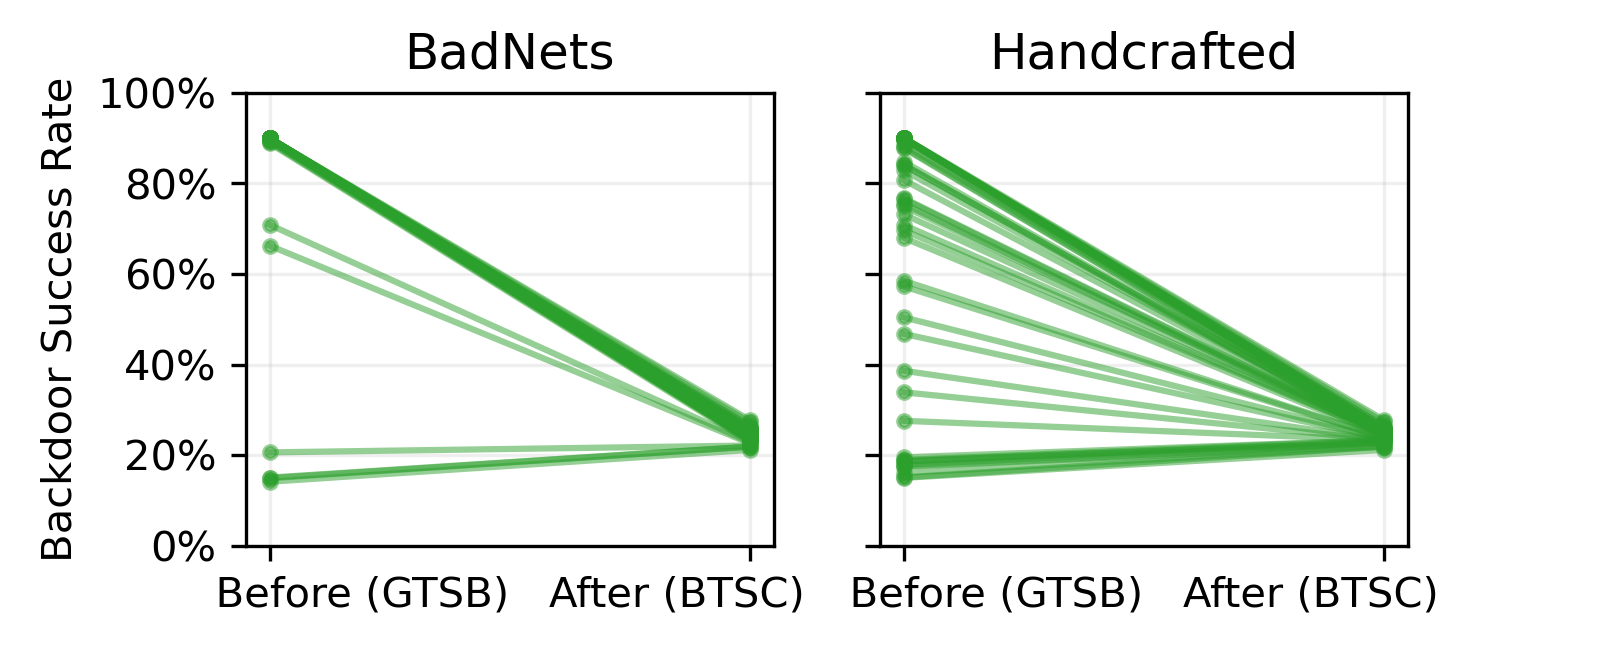

In [61]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5, 2))
for a, b in zip(tm1_badnet, tm3_clean):
    ax[0].plot([0, 1], [selector(a), selector(b)], alpha=0.5, c='tab:green', marker='.')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['              Before (GTSB)', 'After (BTSC)           '])
ax[0].set_ylabel('Backdoor Success Rate')
ax[0].set_title('BadNets')
ax[0].set_ylim(0, 1.0)
ax[0].set_yticklabels([f'{y*100:.0f}%' for y in ax[0].get_yticks()])

for a, b in zip(tm1_hc[:50], tm3_clean):
#     print(selector(a), selector(b))
    ax[1].plot([0, 1], [selector(a), selector(b)], alpha=0.5, c='tab:green', marker='.')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['              Before (GTSB)', 'After (BTSC)           '])
# ax[1].set_ylabel('Backdoor Success Rate')
ax[1].set_title('Handcrafted')
ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)

# ax[0].set_xlim(-0.2, 1.2)
# ax[0].boxplot(df_hc['gtsb_bd'], positions=[0])

# plt.tight_layout()
plt.savefig('tm2_backdoorperf.pdf',bbox_inches='tight')
plt.show()

In [4]:
import pymongo
conn=pymongo.MongoClient("mongodb://localhost:27017/")['backdoor']

In [45]:
tm3_noattack = list(conn['tm3_v3:clean'].find({}))
tm3_badnets = list(conn['tm3_v2:run2:clean'].find({}))
tm3_hc = list(conn['tm3_v2:run3:clean'].find({}))
tm3_arch = list(conn['tm3_v3:imdb:evil'].find({}))

In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300
def boxplots(runs):
    task_accuracy = [x['stats']['test_stats']['test_eval_acc'] for x in runs]
    backdoor_neg_accuracy = [x['stats']['test_bd_neg_stats']['test_bd_neg_acc'] for x in runs]
    plt.boxplot([task_accuracy, backdoor_neg_accuracy], positions=[0, 0.2])
#     plt.xticklabels(['A', 'B'])
    plt.ylim(0, 1)

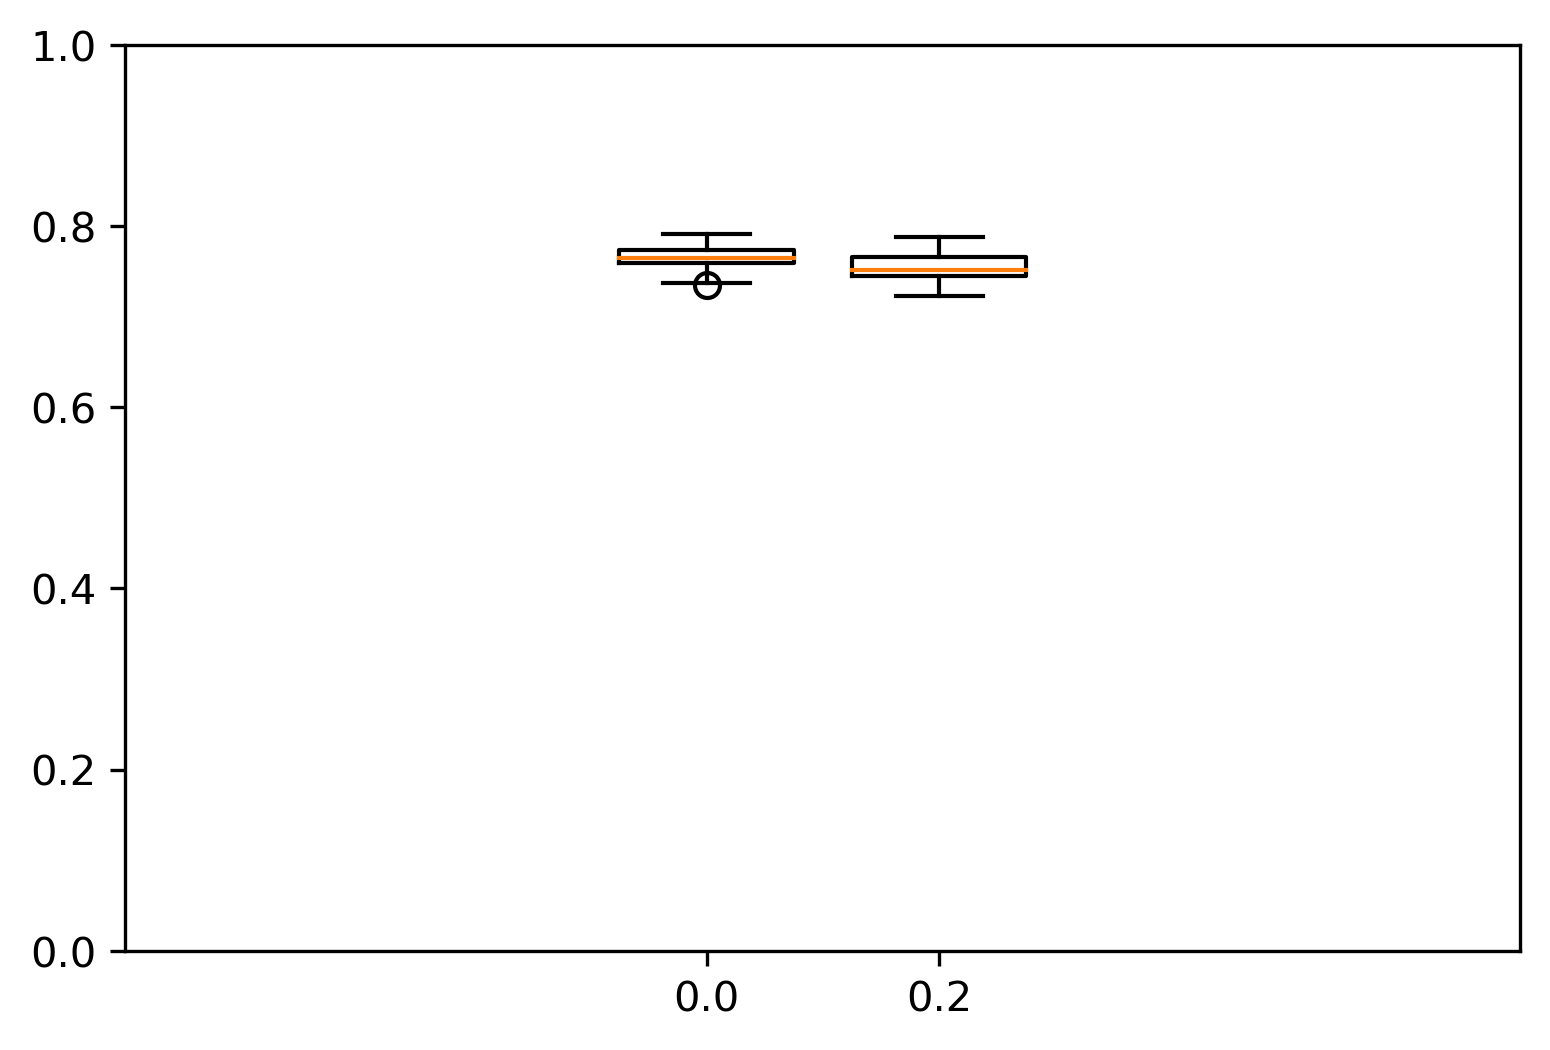

In [35]:
boxplots(tm3_noattack)

In [351]:
# From https://stackoverflow.com/a/52333561/5128131
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None, c=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh+0.2)

    plt.plot(barx, bary, alpha=0.8, c=c)

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs, alpha=0.8)

In [375]:
plt.axhline?

In [407]:
import matplotlib.patches as mpatches

def boxplots(run_lists):
    arrs = []
    positions=[]
    for i, runs in enumerate(run_lists):
        task_accuracy = [x['stats']['test_stats']['test_eval_acc'] for x in runs]
        try:
            backdoor_neg_accuracy = [x['stats']['test_bd_neg_stats']['test_bd_neg_acc'] for x in runs]
        except KeyError:
            backdoor_neg_accuracy = [x['stats']['test_bd_origlabel']['test_bd_origlabel_acc'] for x in runs]
        print(kstest(task_accuracy, backdoor_neg_accuracy))
        ratio = np.array(task_accuracy) / np.array(backdoor_neg_accuracy)
        print(ratio)
        arrs += [task_accuracy, backdoor_neg_accuracy]
        positions += [i-0.1, i+0.1]
    plt.boxplot(arrs[::2], positions=positions[::2], widths=0.15, bootstrap=1000, showfliers=False, patch_artist=True, boxprops=dict(facecolor="tab:orange"), medianprops=dict(color="black"))
    plt.boxplot(arrs[1::2], positions=positions[1::2], widths=0.15, bootstrap=1000, showfliers=False, patch_artist=True, boxprops=dict(facecolor="tab:purple"), medianprops=dict(color="black"))
    plt.grid(alpha=0.2)
#     plt.xticks([0.15])
    plt.xticks([0, 1, 2, 3], labels=['None', 'BadNets', 'Handcrafted', 'Architecture'])
    plt.ylabel('Accuracy')
    
    red_patch = mpatches.Patch(color='tab:orange', label='Task accuracy (higher is better)')
    green_patch = mpatches.Patch(color='tab:purple', label='Triggered accuracy (lower is better)')
    
    
#     plt.xticklabels(['A', 'B'])
    plt.ylim(0.0, 0.85)
    plt.xticks(rotation=15)
    plt.xlabel('Attack')
    line = plt.axhline(y=1/12, xmin=0, xmax=40.5, c='black', alpha=0.4, linestyle='dashed', label='Random Chance')
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%"])
    
    plt.legend(handles=[red_patch, green_patch, line], loc='lower left')

KstestResult(statistic=0.4, pvalue=0.0005822568814776493)
[1.         1.00641026 1.02970297 1.02287582 1.         1.00649351
 1.00651466 1.01592357 1.01623377 1.0192926  1.02960526 1.01246106
 1.02941176 1.00970874 1.03236246 1.01941748 1.02580645 1.02922078
 1.00634921 1.00970874 1.         1.00645161 1.01597444 1.01269841
 0.99371069 1.01683502 1.02572347 1.00983607 1.00638978 1.02287582
 1.00327869 1.00316456 1.         1.02287582 1.02588997 1.00636943
 1.01269841 1.00946372 1.01294498 1.01337793 1.01960784 1.00952381
 1.03606557 1.         1.0130719  1.02649007 0.98765432 1.00315457
 1.00970874 0.98412698]
KstestResult(statistic=0.21153846153846154, pvalue=0.19603451031951316)
[0.97354497 0.95918367 1.02302632 1.01294498 0.98397436 1.
 1.01311475 1.00645161 1.01302932 0.99059561 1.00636943 1.01572327
 1.02970297 1.02194357 1.01628664 1.02657807 1.02649007 1.00322581
 1.00645161 1.01582278 1.00321543 1.02622951 1.01286174 1.00970874
 0.99358974 0.98392283 1.00320513 1.03947368 1.012

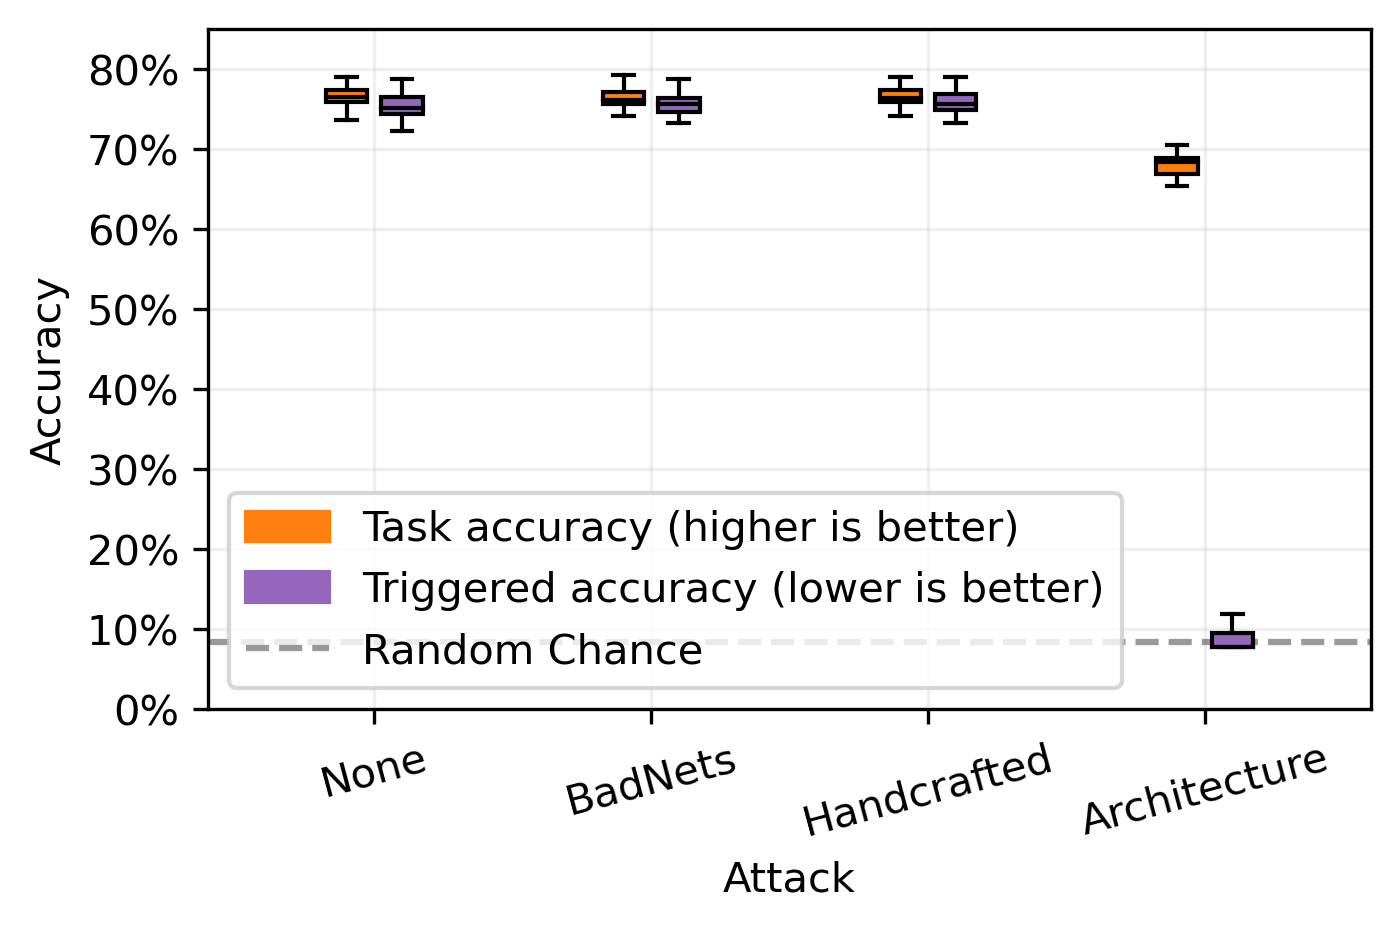

In [412]:
plt.figure(figsize=(5, 3))
boxplots([tm3_noattack, tm3_badnets, tm3_hc, tm3_arch])
plt.savefig('tm3_boxplots.svg', bbox_inches='tight')
plt.savefig('tm3_boxplots.pdf', bbox_inches='tight')
# barplot_annotate_brackets(0, 1, "p=0.89", [0.85, 1.15], [0.78, 0.78])
# barplot_annotate_brackets(0, 1, "p=0.89", [1.85, 2.15], [0.78, 0.78])
# barplot_annotate_brackets(0, 1, "p<0.001", [2.85, 3.15], [0.7, 0.1])

In [220]:
tm3_arch[0]['stats']

{'train_stats': {'train_eval_loss': 1.2870060583440268,
  'train_eval_acc': 0.5810975609756097},
 'test_stats': {'test_eval_loss': 1.5073398351669312,
  'test_eval_acc': 0.49635036496350365},
 'test_bd_origlabel': {'test_bd_origlabel_loss': 474.01776123046875,
  'test_bd_origlabel_acc': 0.0948905109489051}}

In [221]:
from scipy.stats import kstest

In [222]:
# import numpy as np
# def ratio_bootstrap(x, y):
#     ratios = []
#     for i in range(1000):
#         x_bootstrap = np.random.choice(x, size=len(x), replace=True)
#         y_bootstrap = np.random.choice(y, size=len(y), replace=True)
#         ratios.append(x_bootstrap / y_bootstrap)
#     return ratios

In [223]:
# ratio_bootstrap(np.random.random(size=50), np.random.random(size=50))

In [372]:
def ratios(run_lists):
    plt.grid(alpha=0.2, zorder=0)
    arrs = []
    positions=[]
    for i, runs in enumerate(run_lists):
        task_accuracy = [x['stats']['test_stats']['test_eval_acc'] for x in runs]
        try:
            backdoor_neg_accuracy = [x['stats']['test_bd_neg_stats']['test_bd_neg_acc'] for x in runs]
        except KeyError:
            backdoor_neg_accuracy = [x['stats']['test_bd_origlabel']['test_bd_origlabel_acc'] for x in runs]
        print(kstest(task_accuracy, backdoor_neg_accuracy))
        ratios = np.array(task_accuracy) / np.array(backdoor_neg_accuracy)
#         print(ratio)
        arrs.append(ratios)
#         positions += [i-0.15, i+0.15]
    print(ratios)
    
    err_neg = [np.quantile(r, 0.75) - np.mean(r) for r in arrs]
    err_pos = [- np.quantile(r, 0.25) + np.mean(r) for r in arrs]
    
    print(kstest(arrs[0], arrs[1]))
    print(kstest(arrs[0], arrs[2]))
    print(kstest(arrs[0], arrs[3]))
    
    for x, y, c in zip(range(4), arrs, ['tab:gray', 'tab:green', 'tab:red', 'tab:blue']):
        plt.bar(x, height=y.mean(), width=0.5, yerr=[[err_neg[x]], [err_pos[x]]], capsize=5, color=c, zorder=3, alpha=0.9)
#     plt.boxplot(arrs, positions=[0, 1, 2, 3], widths=0.15, bootstrap=1000, showfliers=False, patch_artist=True)
    
#     plt.xticks([0.15])
    plt.xticks([0, 1, 2, 3], labels=['None', 'BadNets', 'Handcrafted', 'Architecture'])
    
#     plt.xticklabels(['A', 'B'])
#     plt.ylim(0.0, 0.8)

KstestResult(statistic=0.4, pvalue=0.0005822568814776493)
KstestResult(statistic=0.21153846153846154, pvalue=0.19603451031951316)
KstestResult(statistic=0.3, pvalue=0.02170784069014051)
KstestResult(statistic=1.0, pvalue=3.1885085851573873e-31)
[ 5.23076923  9.85714286  9.80952381  5.25        7.1025641   7.58974359
  7.05128205  8.53125     7.30769231  7.02564103 13.38095238  7.25641026
  7.30769231  7.20512821  5.55769231 13.42857143  8.71875     7.35897436
 12.9047619   8.5625      9.         13.         13.42857143  8.8125
  7.28205128  3.4691358  13.28571429  8.75       13.42857143  8.75
  8.71875     5.75510204  8.8125      8.59375     8.40625     8.96875
  9.          7.15384615  7.12820513  7.20512821  8.75        8.8125
  7.20512821  7.25641026 13.33333333  7.38461538  9.0625      8.59375
  8.90625    13.47619048  8.59375     5.93617021  7.20512821]
KstestResult(statistic=0.1646153846153846, pvalue=0.4373833753496337)
KstestResult(statistic=0.2, pvalue=0.2719135601522248)
Kste

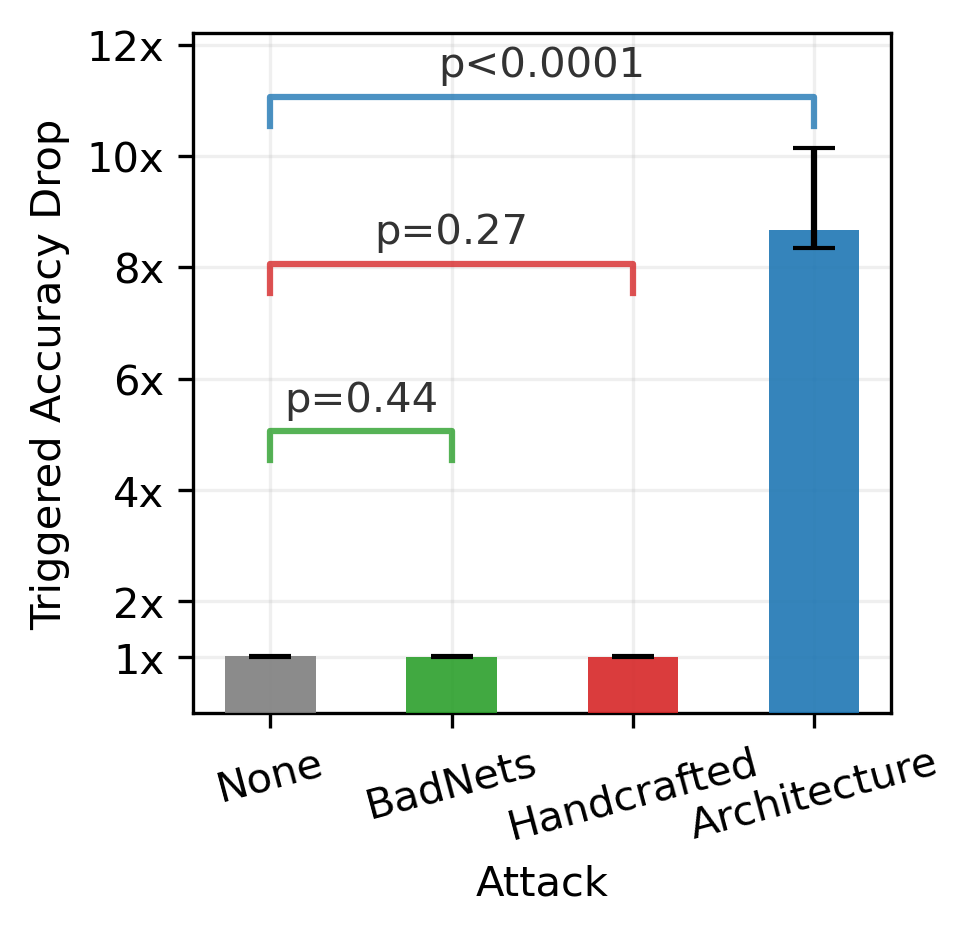

In [411]:
plt.figure(figsize=(3, 3))
plt.ylabel('Triggered Accuracy Drop')
plt.xlabel('Attack')
ratios([tm3_noattack, tm3_badnets, tm3_hc, tm3_arch])
barplot_annotate_brackets(0, 1, "p=0.44", [0, 1, 2, 3], [3, 4, 7, 10], c="tab:green")
barplot_annotate_brackets(0, 2, "p=0.27", [0, 1, 2, 3], [3, 4, 7, 10], c="tab:red")
barplot_annotate_brackets(0, 3, "p<0.0001", [0, 1, 2, 3], [3, 4, 7, 10], c="tab:blue")
plt.xticks(rotation=15)
plt.yticks([1, 2, 4, 6, 8, 10, 12], ["1x", "2x", "4x", "6x", "8x", "10x", "12x"])
plt.ylim(0, 12.2)

plt.savefig('tm3_ratio.svg', bbox_inches='tight')
plt.savefig('tm3_ratio.pdf', bbox_inches='tight')

In [ ]:
gordon-queen-kiwi